In [1]:
import glob 
import os 

root = 'untampered_scans/cancer_nodule_mask'
folders = { name.split('/')[-1]: name for name in glob.glob(root+'/*')}

print("%d untamperd CT scans" % len(folders))


883 untamperd CT scans


In [2]:
import pandas as pd

df = pd.DataFrame(columns=['id_scan', 'id_nodule', 'id_slice', 'mask_path'])

# CT scan by patient 
for f in folders:
    #print("\n%s" % f)
    #print("\n%s" % folders[f])    
    sub_folders = { name.split('/')[-1]: name for name in glob.glob(folders[f]+"/*")}
    id_scan = f.split("-")[-1]
    
    # Group of masks for the same patient (# I do not know whatthat means???)    
    for sf in sub_folders:
        #print("\n---%s" % sub_folders[sf])
        filenames = { name.split('/')[-1]: name for name in glob.glob(sub_folders[sf]+"/*")}
        id_nodule = sf
        # Masks 
        for fn in filenames:
            #print(fn)
            id_slice = int(fn.split('_')[0])
            df = df.append({'id_scan': id_scan, 'id_nodule': id_nodule, 'id_slice': id_slice, 'mask_path': filenames[fn]}, ignore_index=True)      

In [3]:
patient = '0078'

Loading dicom files ... This may take a moment.
Scan(id=1,patient_id=LIDC-IDRI-0078) has 4 nodules.
Nodule 1 has 4 annotations
Loading dicom files ... This may take a moment.
Annotation slice =  26
LuNoTimslices =  [23 24 25 26 27 28]


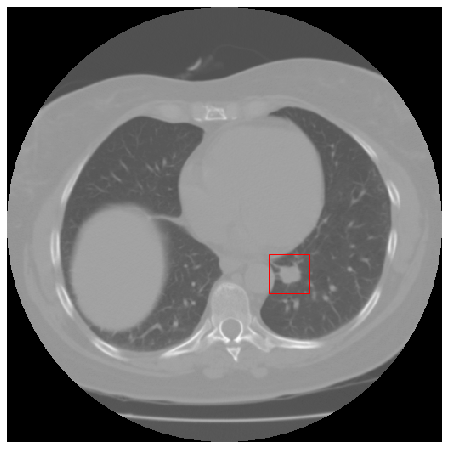

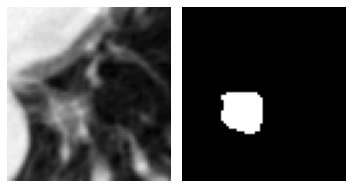

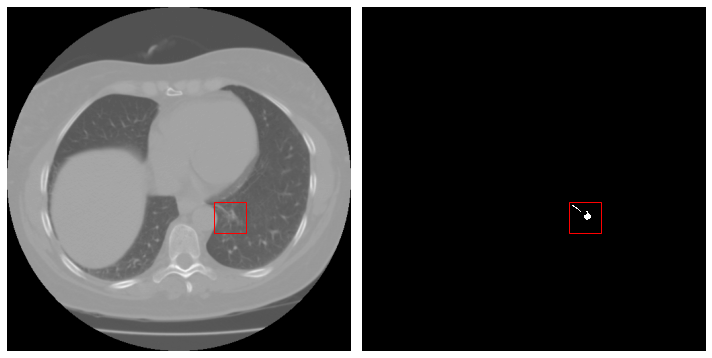

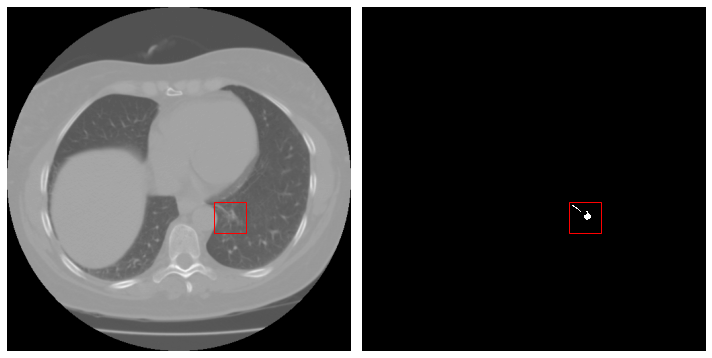

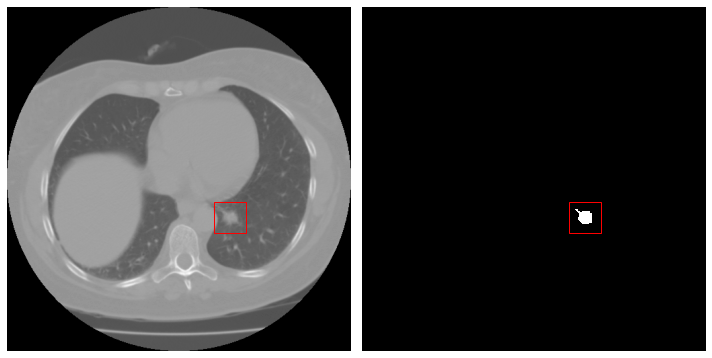

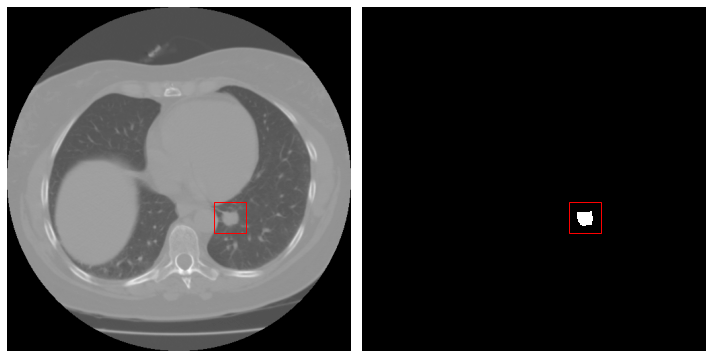

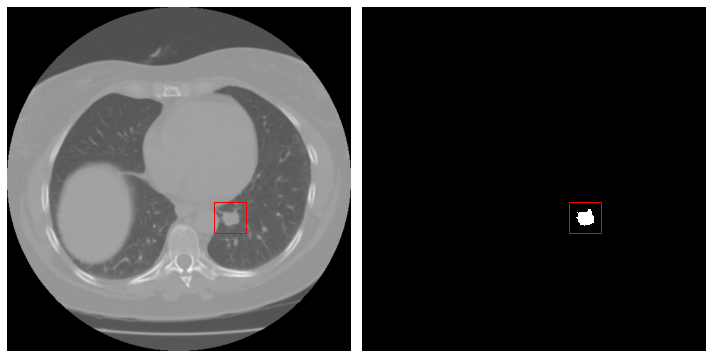

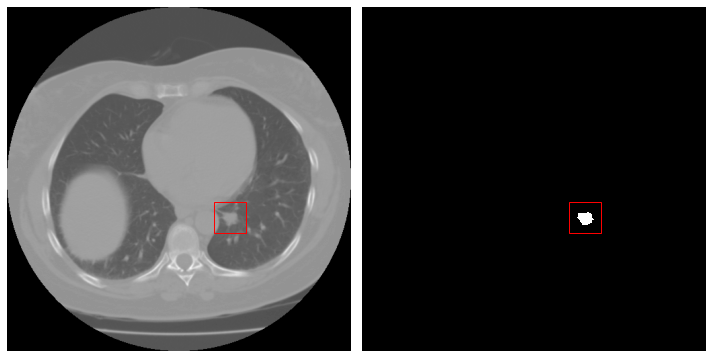

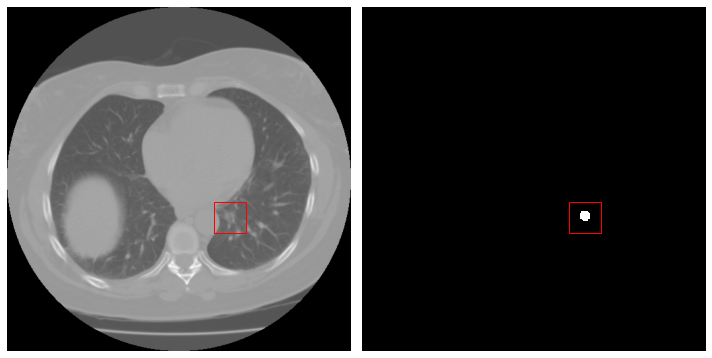

Nodule 2 has 4 annotations
Loading dicom files ... This may take a moment.
Annotation slice =  46
LuNoTimslices =  [44 45 46 47 48 49]


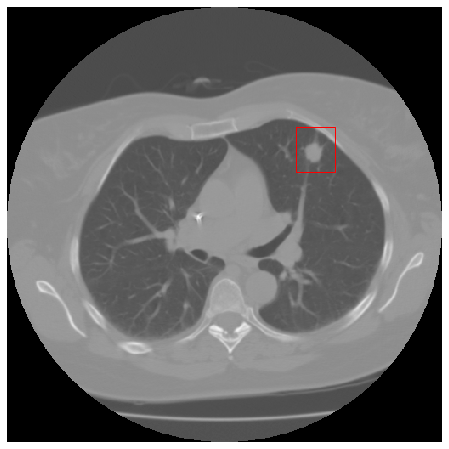

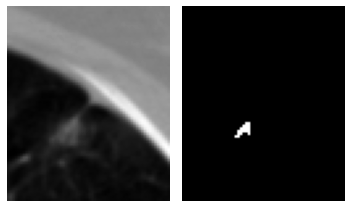

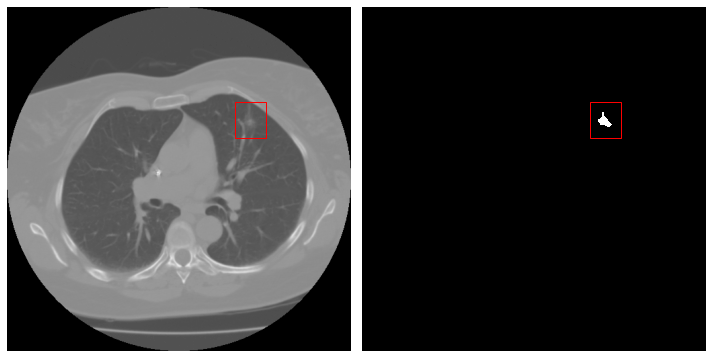

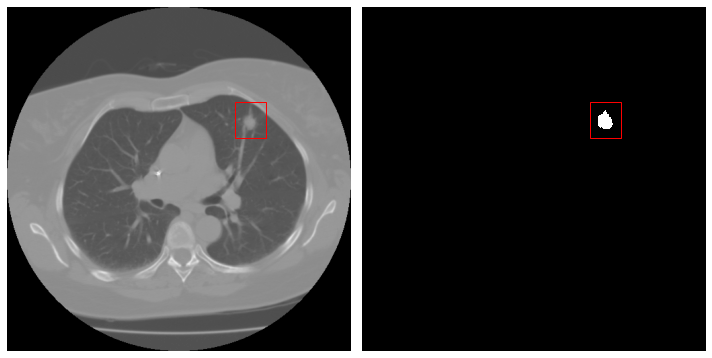

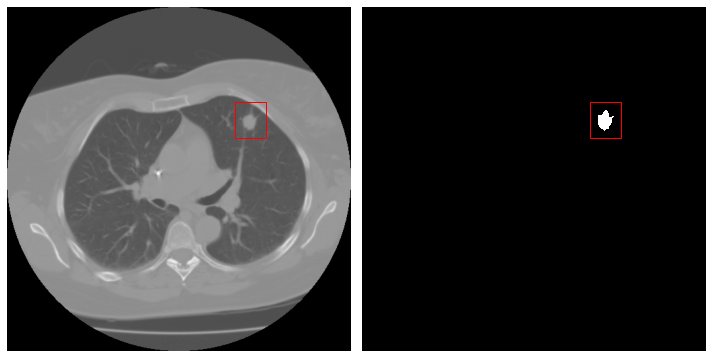

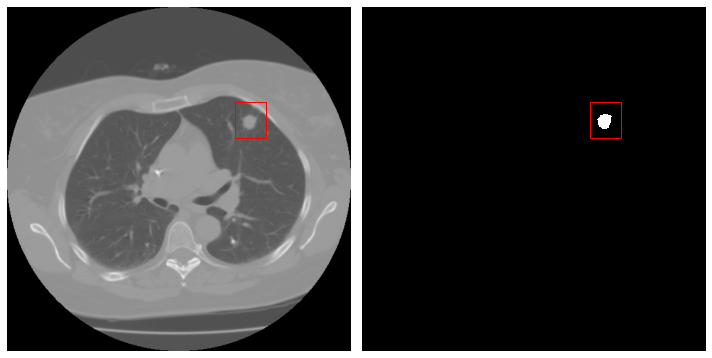

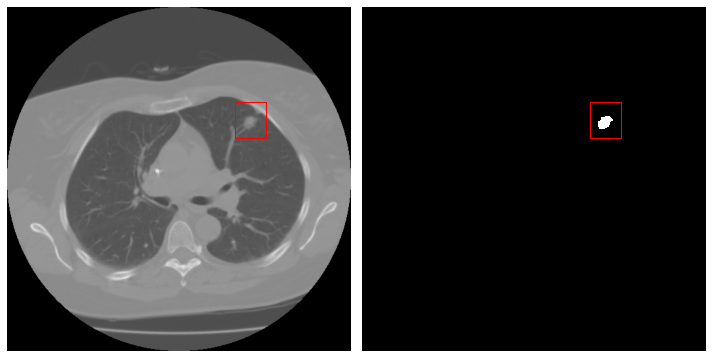

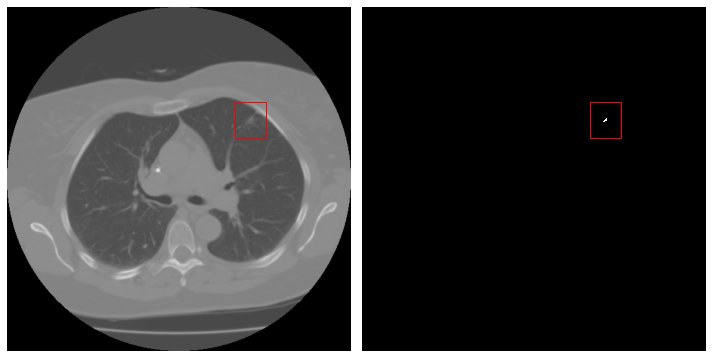

Nodule 3 has 1 annotations
Loading dicom files ... This may take a moment.
Annotation slice =  47
LuNoTimslices =  [47 48]


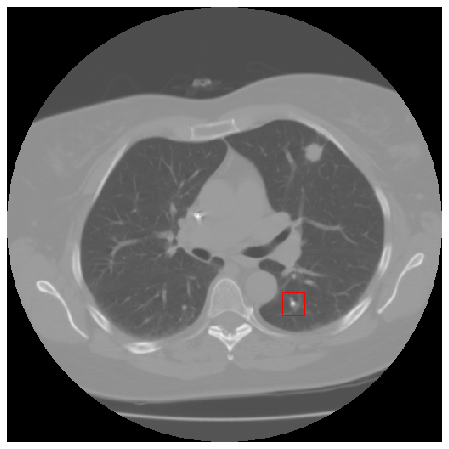

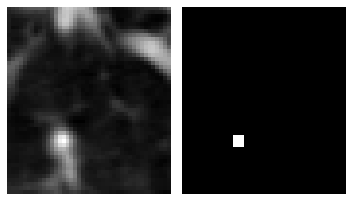

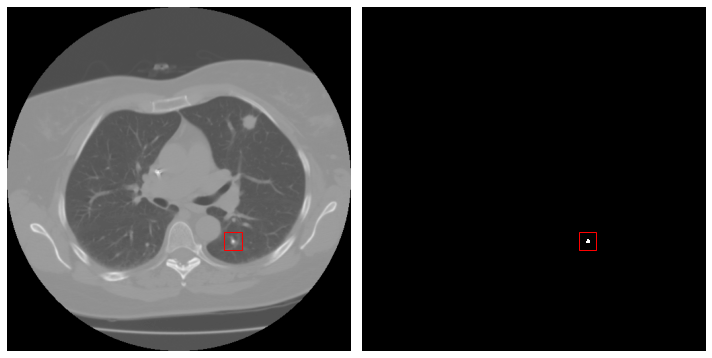

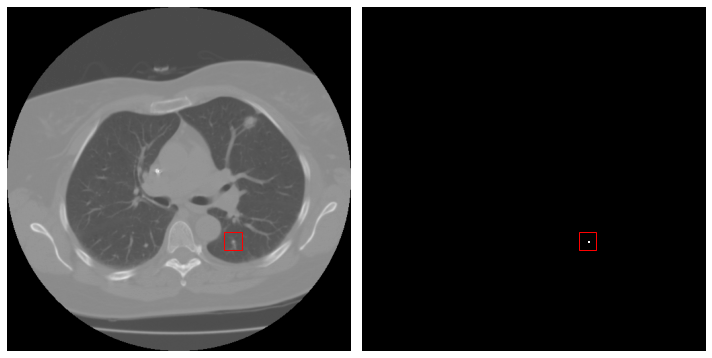

Nodule 4 has 4 annotations
Loading dicom files ... This may take a moment.
Annotation slice =  68
LuNoTimslices =  [64 65 66 67 68 69 70 71]


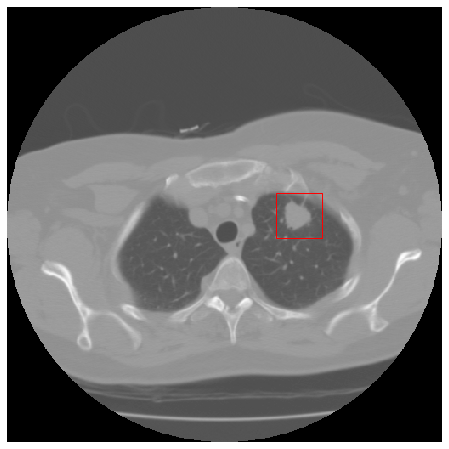

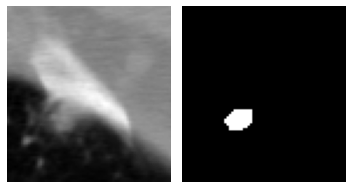

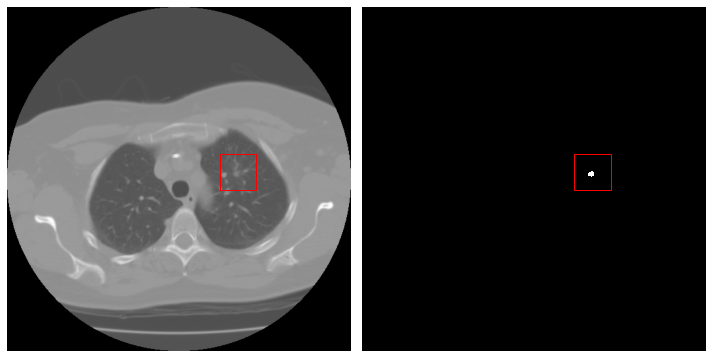

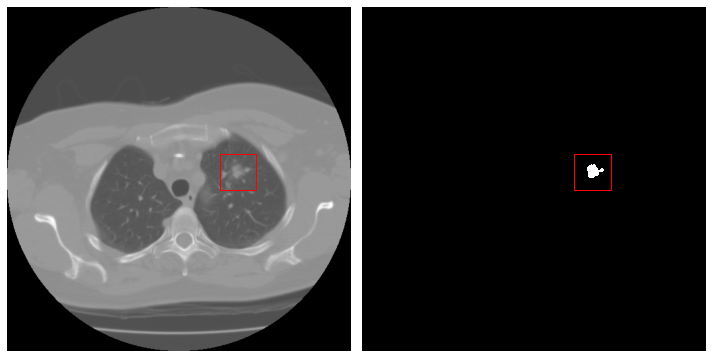

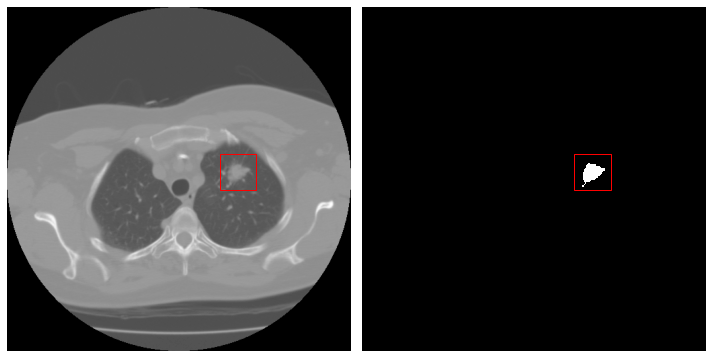

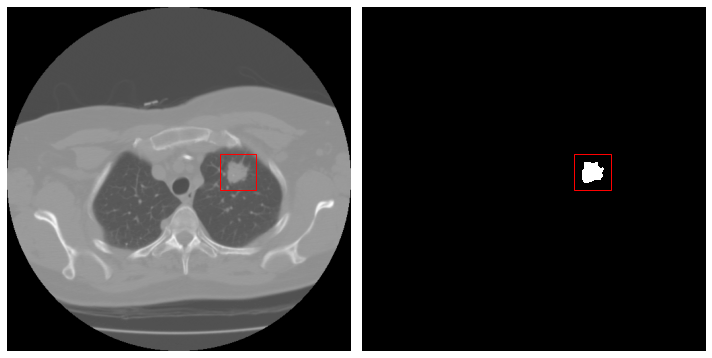

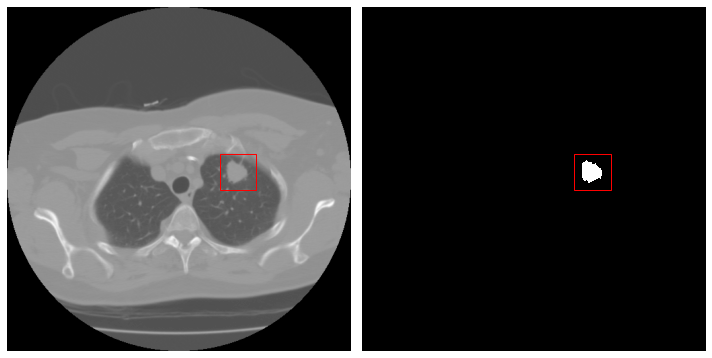

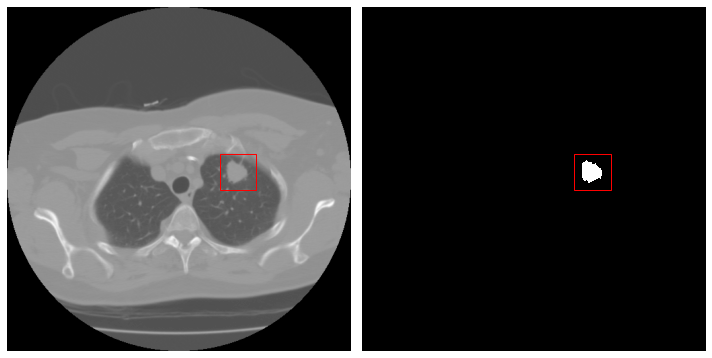

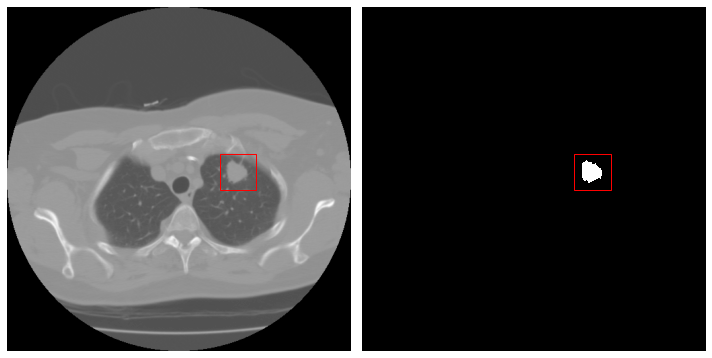

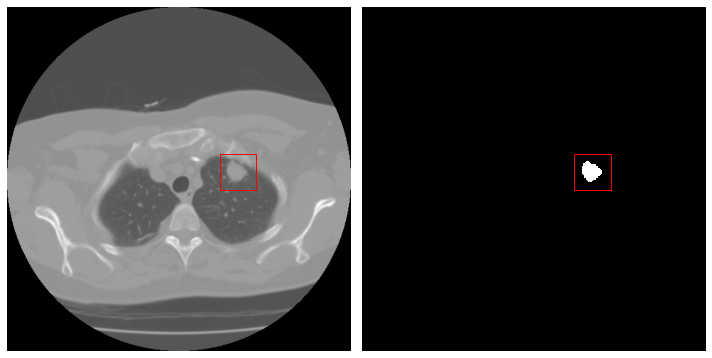

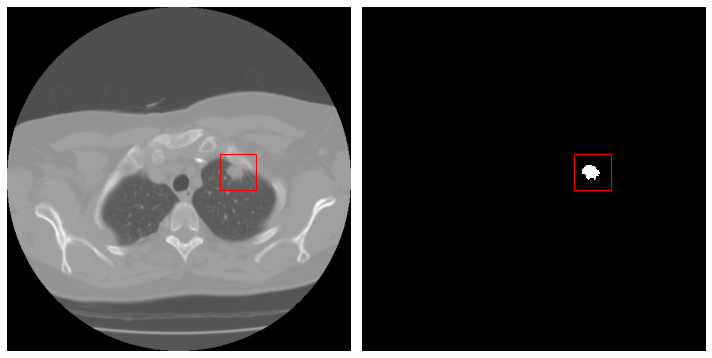

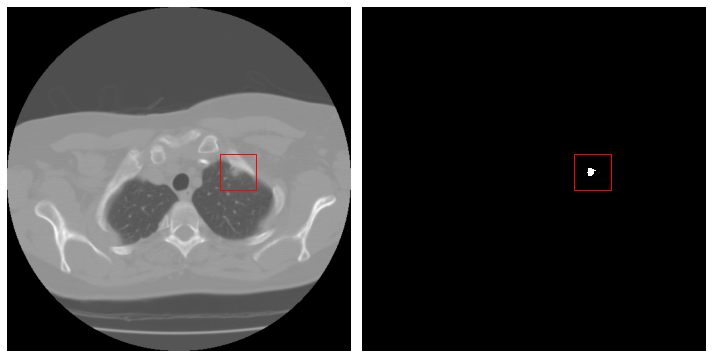

In [15]:
from skimage import measure
import pylidc as pl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Rectangle
import cv2
import numpy as np

sliceData = [] 



pid = 'LIDC-IDRI-'+ patient
scan = pl.query(pl.Scan).filter(pl.Scan.patient_id == pid).first()
nods = scan.cluster_annotations()
images = scan.load_all_dicom_images()

df_patient = df[df['id_scan']== patient][{'id_nodule', 'id_slice'}]
print("%s has %d nodules." % (scan, len(nods)))
for id_n,nod in enumerate(nods):
    #print("Nodule %d has %d annotations - %d masks" % (id_n+1, len(nods[id_n]), count[str(id_n)]))
    print("Nodule %d has %d annotations" % (id_n+1, len(nods[id_n])))
    
    annot = nods[id_n][0]
    vol = annot.scan.to_volume()
    
    i,j,k = annot.centroid
    slice_id = int(np.round(k))
    print('Annotation slice = ', slice_id)
    
    padding = [(30,10), (10,25), (0,0)]
    mask = annot.boolean_mask(pad=padding)
    bbox = annot.bbox(pad=padding)
    bmat = annot.bbox_matrix()
    
    df_nodules = df_patient[df_patient['id_nodule'] == str(id_n)]['id_slice']    
    print('LuNoTimslices = ', df_nodules.values)    
 
    gray = images[slice_id].pixel_array    
    x0, x1 = bmat[1]
    y0, y1 = bmat[0]
    offset = 10
    x = x0-offset
    y = y0-offset
    
    
    rec = Rectangle((x, y), x1-x0+2*offset, y1-y0+2*offset, fc ='none', ec ='r',lw = 1)
    
    fig = plt.figure(figsize=(8,8))    
    ax = fig.add_subplot(111)    
    ax.imshow(gray, cmap = plt.cm.gray, interpolation ='nearest')
    ax.add_patch(rec)
    ax.axis('off')
    #plt.plot(j, i, '.r', label="Nodule centroid")
    plt.show()    
         
    fig,ax = plt.subplots(1,2,figsize=(5,3))
    lim_id = mask.shape[2]-1
    ax[0].imshow(vol[bbox][:,:,lim_id], cmap=plt.cm.gray)
    ax[0].axis('off')
    ax[1].imshow(mask[:,:,lim_id], cmap=plt.cm.gray)
    ax[1].axis('off')
    plt.tight_layout()
    #plt.savefig("../images/mask_bbox.png", bbox_inches="tight")
    plt.show()      

    
    im_seq = [ images[int(s)].pixel_array for s in df_nodules.values ]
    mask_seq = [(np.load(df.iloc[df_i]['mask_path'])).astype(float) for df_i in df_nodules.index ]
    
    
    for index, mask in enumerate(mask_seq):
        regions = measure.label(mask)
        reg_props = measure.regionprops(regions)
    
        #print("regions ", len(reg_props))
        if reg_props:            
            for prop in reg_props:
                min_row, min_col, max_row, max_col = prop.bbox

                fig,ax = plt.subplots(1,2,figsize=(10,10))                
                ax[0].imshow(im_seq[index], cmap=plt.cm.gray)
                rec = Rectangle((x,y), x1-x0+2*offset, y1-y0+2*offset, fc ='none', ec ='r',lw = 1)
                ax[0].add_patch(rec)
                ax[0].axis('off')
                ax[1].imshow(mask, cmap=plt.cm.gray, interpolation ='nearest')
                rec = Rectangle((x,y), x1-x0+2*offset, y1-y0+2*offset, fc ='none', ec ='r',lw = 1)
                ax[1].add_patch(rec)
                ax[1].axis('off')
                plt.tight_layout()
                #plt.savefig("../images/mask_bbox.png", bbox_inches="tight")
                plt.show()  

